In [1]:
# Cálculo de isoyetas y polígonos de thiessen.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [2]:
# Dirección de los datos.
path = "../Material/Clases/Examen 1/"

# Nombre de la cuenca.
estaciones_n = "ESTACIONES_NOROESTE.csv"

# Datos de estaciones.
nombre_e = "Estaciones_Guerrero_1980.csv"

In [3]:
# Cargamos la lista de estaciones.
estaciones = pd.read_csv(path + estaciones_n)

# Nombres de archivos
estaciones["ARCHIVO"] = estaciones["ESTACION"].apply(
    lambda x: f"Estacion_{x}__90_dias.csv" )

# Creamos un punto con las coordenadas.
estaciones["geometry"] = None
estaciones["geometry"] = gpd.points_from_xy(
    estaciones["LONGITUD"], estaciones["LATITUD"])

# Creamos un GeoDataFrame.
estaciones = gpd.GeoDataFrame(estaciones, geometry = "geometry", crs = 4326)
# A coordenadas Cónica Conforme de Lambert ITRF2008.
CRS = 6372
estaciones = estaciones.to_crs(CRS)

# Actualizamos x, y.
estaciones["x"] = estaciones.centroid.x
estaciones["y"] = estaciones.centroid.y

# Datos.
estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   

                           geometry             x             y  
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06  
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06  
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06  
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06  
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06  
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06  
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06  
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06  
8   POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06  
9   POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06  
10  POINT (1115628.012 2348658.379)  1.115628e+06  2.348658e+06

In [4]:
# Graficamos las estaciones.
estaciones.explore()

In [5]:
df = []
df_d = []
ll_l = ["2023-01-01"]
ll = [0] * len(ll_l)

for i in range( estaciones.shape[0] ): 
    df.append( pd.read_csv(path + estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"]) )
    df[i].index = pd.to_datetime( df[i].index )

    df_d.append( df[i].resample("D").sum().sort_values(
        "Precipitacion (mm)", ascending = False) )
    for j in range( len(ll_l) ):
        k = df_d[i].head(6).index.isin([ll_l[j]]).sum()
        ll[j] += k
    if ll[j] == 0: 
        print(f"Estación sin precipitacion: {estaciones.loc[i, 'ESTACION']}")


print(f"Cantidad de estaciones con precipitacion el {ll_l[0]}: {ll[0]}")
print(f"Total de estaciones: {estaciones.shape[0]}")

Cantidad de estaciones con precipitacion el 2023-01-01: 11
Total de estaciones: 11


In [6]:
i = 0

pluviograma = pd.read_csv(path + estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"])
pluviograma.index = pd.to_datetime( pluviograma.index )
pluviograma = pluviograma[ ( pluviograma.index.month.isin([1])
        & pluviograma.index.day.isin([1]) ) ].iloc[50:-9]
pluviograma.columns = [ estaciones.loc[0, "ESTACION"] ]

for i in range( 1, estaciones.shape[0] ): 
    df = pd.read_csv(path + estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"])
    df.index = pd.to_datetime( df.index )
    df = df[ ( df.index.month.isin([1])
        & df.index.day.isin([1, 1]) ) ].iloc[50:-9]
    
    pluviograma[ estaciones.loc[i, "ESTACION"] ] = df["Precipitacion (mm)"]

pluviograma.iloc[-1, 1] = 0
pluviograma.iloc[-4, 1] = 0.2
pluviograma.iloc[-7, 1] = 0.5

pluviograma = pluviograma.iloc[::-1]

pluviograma

EJIDO_NUEVO_LEON  ISLA_CORONADO  ISLA_GUADALUPE  \
Fecha Local                                                            
2023-01-01 01:30:00               0.0            0.0             NaN   
2023-01-01 01:40:00               0.0            NaN             NaN   
2023-01-01 01:50:00               0.0            NaN             NaN   
2023-01-01 02:00:00               0.0            0.2             NaN   
2023-01-01 02:10:00               0.0            NaN             NaN   
...                               ...            ...             ...   
2023-01-01 14:50:00               0.0            NaN             NaN   
2023-01-01 15:00:00               0.0            NaN             NaN   
2023-01-01 15:10:00               0.0            NaN             NaN   
2023-01-01 15:20:00               0.0            NaN             NaN   
2023-01-01 15:30:00               0.0            NaN             NaN   

                     LARUMOROSA  MEXICALI_EMA  PLAYASROSARITO  \
Fecha Local                                                     
2023-01-01 01:30:00        0.00           0.0             0.0   
2023-01-01 01:40:00        0.00           0.0             0.0   
2023-01-01 01:50:00        0.00           0.0             0.0   
2023-01-01 02:00:00        0.00           0.0             0.0   
2023-01-01 02:10:00        0.00           0.0             0.4   
...                         ...           ...             ...   
2023-01-01 14:50:00        0.00           0.0             0.0   
2023-01-01 15:00:00        0.00           0.0             0.0   
2023-01-01 15:10:00        0.25           0.0             0.0   
2023-01-01 15:20:00        0.00           0.0             0.0   
2023-01-01 15:30:00        0.00           0.0             0.0   

                     PRESAABELARDOLRODRIGUEZTIJUANA  \
Fecha Local                                           
2023-01-01 01:30:00                             0.0   
2023-01-01 01:40:00                             0.0   
2023-01-01 01:50:00                             0.0   
2023-01-01 02:00:00                             0.0   
2023-01-01 02:10:00                             0.0   
...                                             ...   
2023-01-01 14:50:00                             0.0   
2023-01-01 15:00:00                             0.0   
2023-01-01 15:10:00                             0.0   
2023-01-01 15:20:00                             0.0   
2023-01-01 15:30:00                             0.0   

                     PRESAEMILIOLOPEZZAMORAENSENADA  SAN_FELIPE  SANQUINTIN  \
Fecha Local                                                                   
2023-01-01 01:30:00                             0.0         0.0         0.0   
2023-01-01 01:40:00                             0.0         0.0         0.0   
2023-01-01 01:50:00                             0.0         0.0         0.0   
2023-01-01 02:00:00                             0.0         0.0         0.0   
2023-01-01 02:10:00                             0.0         0.0         0.0   
...                                             ...         ...         ...   
2023-01-01 14:50:00                             0.0         0.0         0.0   
2023-01-01 15:00:00                             0.0         0.0         0.0   
2023-01-01 15:10:00                             0.0         0.0         0.0   
2023-01-01 15:20:00                             0.0         0.0         0.0   
2023-01-01 15:30:00                             0.0         0.0         0.0   

                     TECATE  
Fecha Local                  
2023-01-01 01:30:00     0.0  
2023-01-01 01:40:00     0.0  
2023-01-01 01:50:00     0.0  
2023-01-01 02:00:00     0.0  
2023-01-01 02:10:00     0.0  
...                     ...  
2023-01-01 14:50:00     0.2  
2023-01-01 15:00:00     0.2  
2023-01-01 15:10:00     0.2  
2023-01-01 15:20:00     0.2  
2023-01-01 15:30:00     0.2  

[85 rows x 11 columns]

Index(['EJIDO_NUEVO_LEON', 'ISLA_CORONADO', 'ISLA_GUADALUPE', 'LARUMOROSA',
       'MEXICALI_EMA', 'PLAYASROSARITO', 'PRESAABELARDOLRODRIGUEZTIJUANA',
       'PRESAEMILIOLOPEZZAMORAENSENADA', 'SAN_FELIPE', 'SANQUINTIN', 'TECATE'],
      dtype='object')

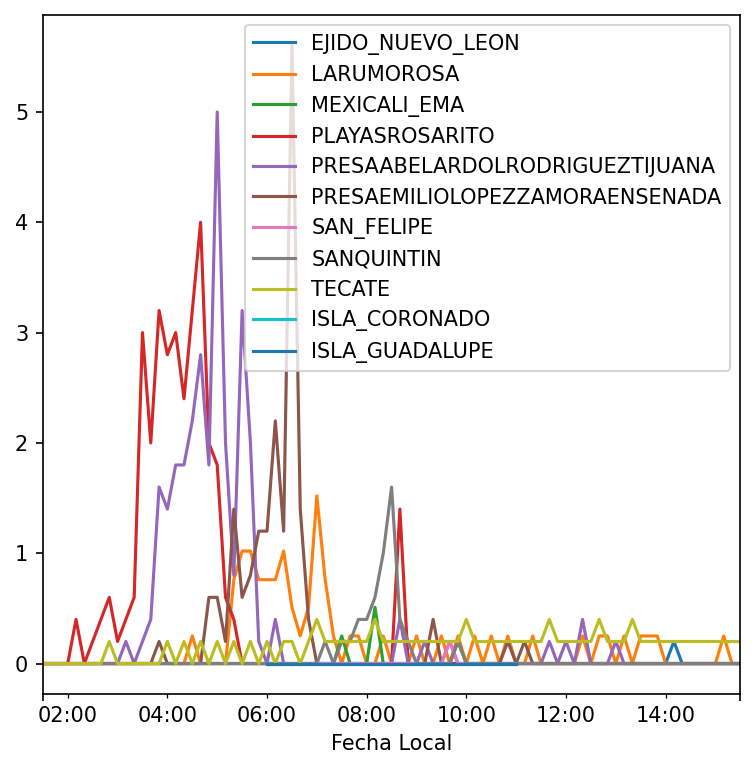

In [7]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

pluviograma.drop( ["ISLA_CORONADO", "ISLA_GUADALUPE"], axis = 1).plot(ax = ax)
pluviograma[["ISLA_CORONADO", "ISLA_GUADALUPE"]].iloc[27::3].plot(ax = ax)
pluviograma.columns

In [8]:
# Subcuencas.

RH = "RH01"

subc = gpd.read_file(path + "subcuenca.shp")
subc = subc.to_crs(crs = CRS)
subc["CVE_RH"] = subc["CVE_SUBCUE"].apply(lambda x: x[0:4])
subc["AREA"] = subc.area
subc["PERIMETRO"] = subc.length
subc[subc["CVE_RH"] == RH].explore()

In [9]:
buffer = 110000
bounds = subc[subc["CVE_RH"] == RH].total_bounds
bbox = [ [ bounds[0] - buffer, bounds[1] - buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[1] - buffer ],
         [ bounds[2] + buffer, bounds[1] - buffer ],
         [ bounds[2] + buffer, ( bounds[1] + bounds[3] ) / 2 ],
         [ bounds[2] + buffer, bounds[3] + buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[3] + buffer ],
         [ bounds[0] - buffer, bounds[3] + buffer ],
         [ bounds[0] - buffer, ( bounds[1] + bounds[3] ) / 2 ] ]
for i in range( len(bbox) ):
    bbox[i] = ( [f"B{i + 1}"] + [None] * 6
        + [shp.geometry.Point(bbox[i]), bbox[i][0], bbox[i][1] ] )
estaciones = pd.concat([estaciones,
    pd.DataFrame(bbox, columns = estaciones.columns)]
    ).reset_index( drop = True )

estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   
11                              B1        NaN         NaN             None   
12                              B2        NaN         NaN             None   
13                              B3        NaN         NaN             None   
14                              B4        NaN         NaN             None   
15                              B5        NaN         NaN             None   
16                              B6        NaN         NaN             None   
17                              B7        NaN         NaN             None   
18                              B8        NaN         NaN             None   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   
11                None      NaN   
12                None      NaN   
13                None      NaN   
14                None      NaN   
15                None      NaN   
16                None      NaN   
17                None      NaN   
18                None      NaN   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   
11                                               None   
12                                               None   
13                                               None   
14                                               None   
15                                               None   
16                                               None   
17                                               None   
18                                               None   

                           geometry             x             y  
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06  
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06  
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06  
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06  
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06  
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06  
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06  
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06  
8   POINT (1271148.725 216142

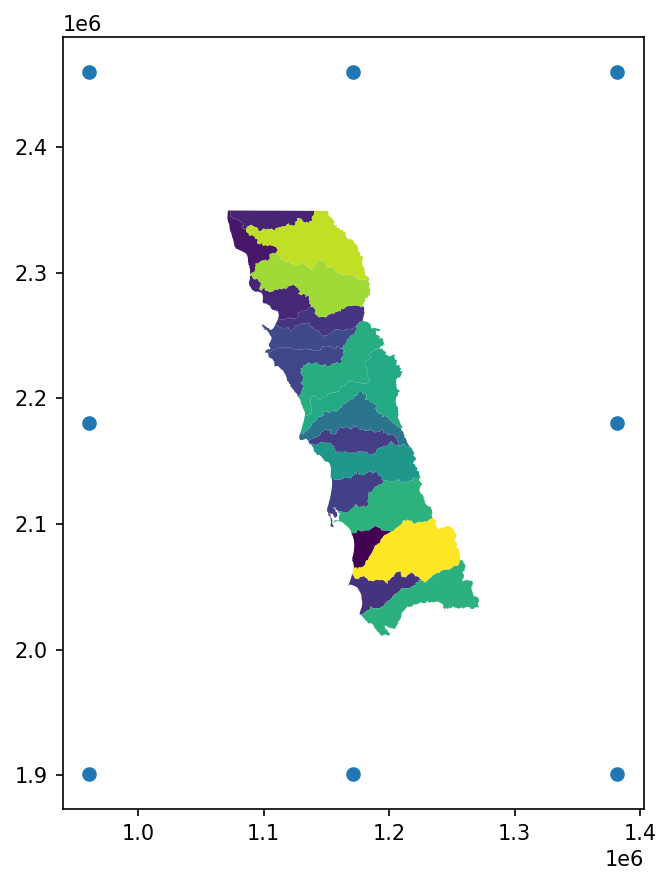

In [10]:
# Límites

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax)
# Graficamos los límites.
estaciones[11:].plot(ax = ax)

fig.tight_layout()
plt.show()

In [11]:
# Polígonos de Thiessen

# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( estaciones[ ["x", "y"] ] )

# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.

# Lista de geometrías de Shapely.
Poly_th = []

# Iteramos para cada lista de vértices que forman un polígono.
for i in Thiessen.point_region:

    # Creamos la lista de vértices.
    Ver_th = []

    # Saltamos las listas vacías.
    if len(Thiessen.regions[i]) == 0: pass
    else:
        if -1 in Thiessen.regions[i]:
            Poly_th.append( shp.geometry.Polygon( ) )
    
        # Agregamos cada vértice que corresponde al polígono de Thiessen.
        else:
            for j in Thiessen.regions[i]:
                Ver_th.append( Thiessen.vertices[j] )

            # Agregamos nuevamente el primer vértice para cerrar el polígono.
            Ver_th.append( Ver_th[0] )

            # Convertimos a geometría de shapely.
            Poly_th.append( shp.geometry.Polygon( Ver_th ) )

# Creamos una columna del GeoDataframe con los polígonos de Thiessen.
estaciones["Thiessen"] = Poly_th
# Establecemos como la geometría de trabajo.
estaciones = estaciones.set_geometry("Thiessen")

# Datos.
estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   
11                              B1        NaN         NaN             None   
12                              B2        NaN         NaN             None   
13                              B3        NaN         NaN             None   
14                              B4        NaN         NaN             None   
15                              B5        NaN         NaN             None   
16                              B6        NaN         NaN             None   
17                              B7        NaN         NaN             None   
18                              B8        NaN         NaN             None   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   
11                None      NaN   
12                None      NaN   
13                None      NaN   
14                None      NaN   
15                None      NaN   
16                None      NaN   
17                None      NaN   
18                None      NaN   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   
11                                               None   
12                                               None   
13                                               None   
14                                               None   
15                                               None   
16                                               None   
17                                               None   
18                                               None   

                           geometry             x             y  \
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06   
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06   
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06   
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06   
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06   
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06   
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8   POINT (1271148.7

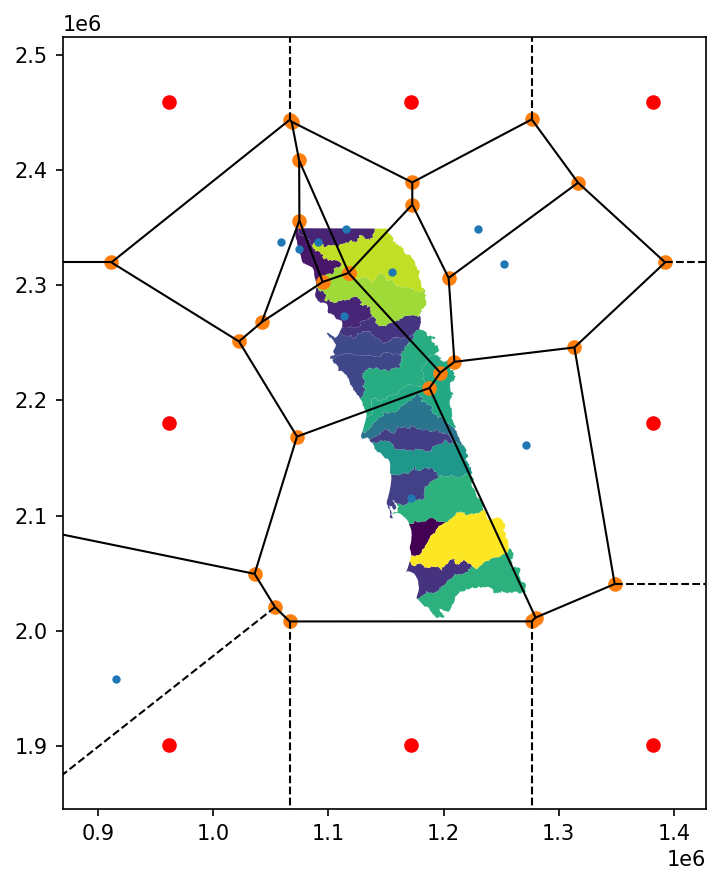

In [12]:
# Polígonos de Thiessen

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax, zorder = 2)
# Graficamos los polígonos de Thiessen.
spatial.voronoi_plot_2d(Thiessen, ax = ax, zorder = 1)
# Graficamos los límites.
estaciones.loc[11:, "geometry"].plot(ax = ax, color = "r", zorder = 3)

fig.tight_layout()
plt.show()

In [13]:
estaciones = estaciones.iloc[:-8].copy()
estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   

                           geometry             x             y  \
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06   
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06   
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06   
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06   
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06   
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06   
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8   POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06   
9   POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06   
10  POINT (1115628.012 2348658.379)  1.115628e+06  2.348658e+06   

                                             Thiessen  
0   POLYGON ((1316789.800 2389152.066, 1392434.676...  
1   POLYGON ((1074749.334 2356291.876, 1074531.774...  
2                            GEOMETRYCOLLECTION EMPTY  
3   POLYGON ((1117550.695 2310977.677, 1172805.057...  
4   POLYGON ((1316789.800 2389152.066, 1204399.021...  
5   POLYGON ((1094972.637 2302951.373, 1042094.526...  
6   POLYGON ((1094972.637 2302951.373, 1117457.215...  
7   POLYGON ((1094972.637 2302951.373, 1117457.215...  
8   POLYGON ((1209384.430 2233564.055, 1197126.945...  
9   POLYGON ((1187752.631 2210872.616, 1279890.670...  
10  POLYGON ((1117550.695 2310977.677, 1172805.057...

In [14]:
estaciones["hp_TOT"] = pluviograma.sum().to_numpy()

estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   

                           geometry             x             y  \
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06   
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06   
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06   
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06   
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06   
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06   
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8   POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06   
9   POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06   
10  POINT (1115628.012 2348658.379)  1.115628e+06  2.348658e+06   

                                             Thiessen  hp_TOT  
0   POLYGON ((1316789.800 2389152.066, 1392434.676...    0.20  
1   POLYGON ((1074749.334 2356291.876, 1074531.774...    7.30  
2                            GEOMETRYCOLLECTION EMPTY    0.51  
3   POLYGON ((1117550.695 2310977.677, 1172805.057...   14.65  
4   POLYGON ((1316789.800 2389152.066, 1204399.021...    0.76  
5   POLYGON ((1094972.637 2302951.373, 1042094.526...   32.60  
6   POLYGON ((1094972.637 2302951.373, 1117457.215...   29.60  
7   POLYGON ((1094972.637 2302951.373, 1117457.215...   18.60  
8   POLYGON ((1209384.430 2233564.055, 1197126.945...    0.20  
9   POLYGON ((1187752.631 2210872.616, 1279890.670...    5.40  
10  POLYGON ((1117550.695 2310977.677, 1172805.057...   13.80

In [15]:
# Graficamos las isoyetas y las guardamos en una variable.
isoyetas = ax.tricontour( estaciones["x"],
    estaciones["y"], estaciones["hp_TOT"], levels = 50 )

# Extraemos las isoyetas y las convertimos en curvas de Shapely.

# Lista con el nivel de las isoyetas repetido
# por cada isoyeta que haya en ese nivel.
hp_level = []
# Cantidad de isoyetas que tiene un nivel.
level_n  = []
# Curvas de cada isoyeta.
level_c  = []

# Iteramos para todos los grupos de isoyetas allsegs.
# Evitamos el primer y último grupo que están vacíos.
for i in range( len(isoyetas.allsegs[1:-1]) ):
    # Contamos la cantidad de isoyetas que hay en un grupo, lo agregamos
    # a la lista level_n e imprimimos los valores.
    level_n.append( len( isoyetas.allsegs[1 + i] ) )
    print(f"nivel {i}: {level_n[i]}")

    # Copiamos el nivel de la isoyeta tantas
    # veces como isoyetas haya en ese nivel.
    hp_level = hp_level + [isoyetas.levels[i]] * level_n[i]

    # Entramos en cada grupo i, que tiene una cantidad level_n[i]
    # de elementos dentro, convertimos cada elemento en una
    # geometría de shapely y lo metemos dentro de una lista
    # de una sola dimensión (como hacer flatten).
    for j in range( 0, level_n[i] ):
        level_c.append( shp.geometry.LineString(isoyetas.allsegs[i + 1][j]) )

# Creamos un DataFrame con los niveles de isoyetas.
df_is = pd.DataFrame(hp_level, columns = ["hp [mm]"])
# Agregamos las geometrías de shapely.
df_is["geometry"] = level_c
# Convertimos en un GeoDataFrame.
df_is = gpd.GeoDataFrame(df_is)
# Establecemos que hemos estado trabajando con coordenadas UTM 11N (m).
df_is = df_is.set_crs(CRS)

df_is

nivel 0: 1
nivel 1: 1
nivel 2: 1
nivel 3: 1
nivel 4: 1
nivel 5: 1
nivel 6: 1
nivel 7: 1
nivel 8: 1
nivel 9: 1
nivel 10: 1
nivel 11: 1
nivel 12: 1
nivel 13: 1
nivel 14: 1
nivel 15: 1
nivel 16: 1
nivel 17: 1
nivel 18: 1
nivel 19: 1
nivel 20: 1
nivel 21: 1
nivel 22: 1
nivel 23: 1
nivel 24: 1
nivel 25: 1
nivel 26: 1
nivel 27: 1
nivel 28: 1
nivel 29: 1
nivel 30: 1
nivel 31: 1
nivel 32: 1
nivel 33: 1
nivel 34: 1
nivel 35: 1
nivel 36: 1
nivel 37: 1
nivel 38: 1
nivel 39: 1


hp [mm]                                           geometry
0       0.0  LINESTRING (921866.429 1974602.704, 918932.859...
1       0.8  LINESTRING (938700.539 2019286.570, 927674.363...
2       1.6  LINESTRING (955534.648 2063970.437, 936415.866...
3       2.4  LINESTRING (972368.758 2108654.304, 945157.370...
4       3.2  LINESTRING (989202.868 2153338.171, 953898.873...
5       4.0  LINESTRING (1006036.978 2198022.038, 962640.37...
6       4.8  LINESTRING (1022871.088 2242705.905, 971381.88...
7       5.6  LINESTRING (1039705.197 2287389.772, 980123.38...
8       6.4  LINESTRING (1056539.307 2332073.639, 988864.88...
9       7.2  LINESTRING (1064780.357 2338843.657, 1059659.5...
10      8.0  LINESTRING (1071793.826 2340197.412, 1060820.6...
11      8.8  LINESTRING (1078807.296 2341551.167, 1061981.8...
12      9.6  LINESTRING (1085820.766 2342904.921, 1063142.9...
13     10.4  LINESTRING (1092834.235 2344258.676, 1064304.0...
14     11.2  LINESTRING (1099847.705 2345612.431, 1065465.1...
15     12.0  LINESTRING (1106861.175 2346966.186, 1066626.3...
16     12.8  LINESTRING (1113874.644 2348319.940, 1067787.4...
17     13.6  LINESTRING (1131856.139 2222920.432, 1149432.0...
18     14.4  LINESTRING (1128346.648 2232485.175, 1142574.7...
19     15.2  LINESTRING (1124837.157 2242049.917, 1135717.4...
20     16.0  LINESTRING (1121327.667 2251614.660, 1128860.1...
21     16.8  LINESTRING (1117818.176 2261179.403, 1122002.9...
22     17.6  LINESTRING (1114308.686 2270744.146, 1115145.6...
23     18.4  LINESTRING (1075915.317 2337731.155, 1066261.4...
24     19.2  LINESTRING (1077076.443 2337735.998, 1066773.5...
25     20.0  LINESTRING (1078237.569 2337740.841, 1067285.6...
26     20.8  LINESTRING (1079398.695 2337745.683, 1067797.7...
27     21.6  LINESTRING (1080559.821 2337750.526, 1068309.8...
28     22.4  LINESTRING (1081720.946 2337755.368, 1068822.0...
29     23.2  LINESTRING (1082882.072 2337760.211, 1069334.1...
30     24.0  LINESTRING (1084043.198 2337765.054, 1069846.2...
31     24.8  LINESTRING (1085204.324 2337769.896, 1070358.3...
32     25.6  LINESTRING (1086365.450 2337774.739, 1070870.5...
33     26.4  LINESTRING (1087526.575 2337779.581, 1071382.6...
34     27.2  LINESTRING (1088687.701 2337784.424, 1071894.7...
35     28.0  LINESTRING (1089848.827 2337789.266, 1072406.8...
36     28.8  LINESTRING (1091009.953 2337794.109, 1072919.0...
37     29.6  LINESTRING (1080903.898 2322466.044, 1086697.8...
38     30.4  LINESTRING (1078698.649 2325810.499, 1082385.6...
39     31.2  LINESTRING (1076493.401 2329154.954, 1078073.5...

In [16]:
df_is.explore()

In [17]:
m = []

for i in range( df_is.shape[0] ):

    g = shp.geometry.Polygon(df_is.loc[i, "geometry"])

    for j in df_is.loc[i + 1:].itertuples():
        g = g.union( shp.geometry.Polygon( j[2] ) )
    
    m.append(g)

df_is["IS_TOT"] = m

df_is

hp [mm]                                           geometry  \
0       0.0  LINESTRING (921866.429 1974602.704, 918932.859...   
1       0.8  LINESTRING (938700.539 2019286.570, 927674.363...   
2       1.6  LINESTRING (955534.648 2063970.437, 936415.866...   
3       2.4  LINESTRING (972368.758 2108654.304, 945157.370...   
4       3.2  LINESTRING (989202.868 2153338.171, 953898.873...   
5       4.0  LINESTRING (1006036.978 2198022.038, 962640.37...   
6       4.8  LINESTRING (1022871.088 2242705.905, 971381.88...   
7       5.6  LINESTRING (1039705.197 2287389.772, 980123.38...   
8       6.4  LINESTRING (1056539.307 2332073.639, 988864.88...   
9       7.2  LINESTRING (1064780.357 2338843.657, 1059659.5...   
10      8.0  LINESTRING (1071793.826 2340197.412, 1060820.6...   
11      8.8  LINESTRING (1078807.296 2341551.167, 1061981.8...   
12      9.6  LINESTRING (1085820.766 2342904.921, 1063142.9...   
13     10.4  LINESTRING (1092834.235 2344258.676, 1064304.0...   
14     11.2  LINESTRING (1099847.705 2345612.431, 1065465.1...   
15     12.0  LINESTRING (1106861.175 2346966.186, 1066626.3...   
16     12.8  LINESTRING (1113874.644 2348319.940, 1067787.4...   
17     13.6  LINESTRING (1131856.139 2222920.432, 1149432.0...   
18     14.4  LINESTRING (1128346.648 2232485.175, 1142574.7...   
19     15.2  LINESTRING (1124837.157 2242049.917, 1135717.4...   
20     16.0  LINESTRING (1121327.667 2251614.660, 1128860.1...   
21     16.8  LINESTRING (1117818.176 2261179.403, 1122002.9...   
22     17.6  LINESTRING (1114308.686 2270744.146, 1115145.6...   
23     18.4  LINESTRING (1075915.317 2337731.155, 1066261.4...   
24     19.2  LINESTRING (1077076.443 2337735.998, 1066773.5...   
25     20.0  LINESTRING (1078237.569 2337740.841, 1067285.6...   
26     20.8  LINESTRING (1079398.695 2337745.683, 1067797.7...   
27     21.6  LINESTRING (1080559.821 2337750.526, 1068309.8...   
28     22.4  LINESTRING (1081720.946 2337755.368, 1068822.0...   
29     23.2  LINESTRING (1082882.072 2337760.211, 1069334.1...   
30     24.0  LINESTRING (1084043.198 2337765.054, 1069846.2...   
31     24.8  LINESTRING (1085204.324 2337769.896, 1070358.3...   
32     25.6  LINESTRING (1086365.450 2337774.739, 1070870.5...   
33     26.4  LINESTRING (1087526.575 2337779.581, 1071382.6...   
34     27.2  LINESTRING (1088687.701 2337784.424, 1071894.7...   
35     28.0  LINESTRING (1089848.827 2337789.266, 1072406.8...   
36     28.8  LINESTRING (1091009.953 2337794.109, 1072919.0...   
37     29.6  LINESTRING (1080903.898 2322466.044, 1086697.8...   
38     30.4  LINESTRING (1078698.649 2325810.499, 1082385.6...   
39     31.2  LINESTRING (1076493.401 2329154.954, 1078073.5...   

                                               IS_TOT  
0   POLYGON ((1094794.17178696 2344447.637309461, ...  
1   POLYGON ((1099847.705009542 2345612.430830879,...  
2   POLYGON ((1101807.641434626 2345801.392010766,...  
3   POLYGON ((1106861.174657208 2346966.185532184,...  
4   POLYGON ((1108821.111082292 2347155.146712071,...  
5   POLYGON ((1113874.644304874 2348319.940233489,...  
6   POLYGON ((1118149.172653232 2348054.482781316,...  
7   POLYGON ((1124396.919396122 2348656.839868547,...  
8   POLYGON ((1125164.298796698 2348053.251549101,...  
9   POLYGON ((1131412.045539588 2348655.608636332,...  
10  POLYGON ((1132179.424940164 2348052.020316886,...  
11  POLYGON ((1138427.171683053 2348654.377404117,...  
12  POLYGON ((1139194.551083629 2348050.789084671,...  
13  POLYGON ((1178452.140588822 2313199.341314358,...  
14  POLYGON ((1142384.610336286 2194226.204113949,...  
15  POLYGON ((1062164.417246807 2336355.681345125,...  
16  POLYGON ((1117381.793252657 2348658.071100762,...  
17  POLYGON ((1131856.138629896 2222920.432141194,...  
18  POLYGON ((1063700.786592538 2335786.907258324,...  
19  POLYGON ((1100825.283938674 2287981.513136375,...  
20  POLYGON ((1093762.930142274 2241818.860605517,...  
21  POLYGON ((1117818.176354709 2261179.402844186,...  
22  POLYG

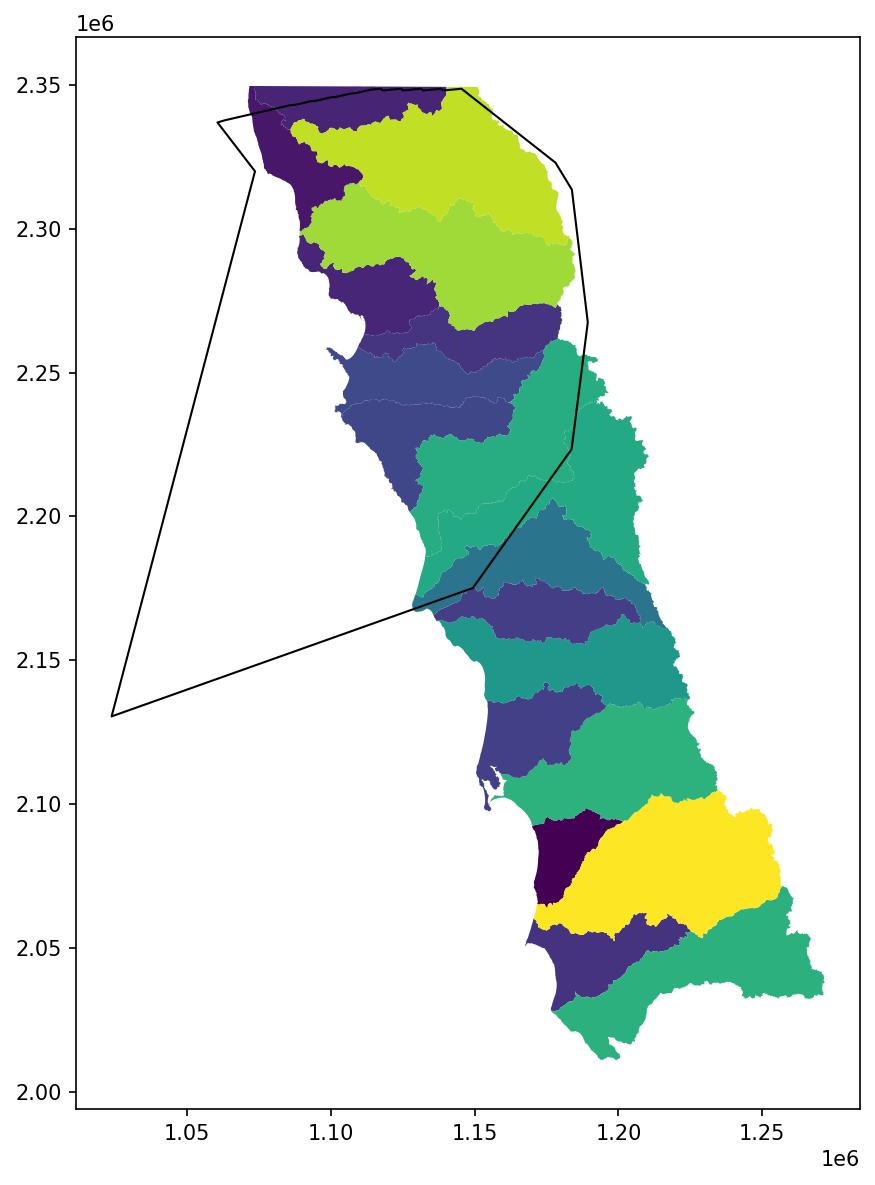

In [18]:
# Polígonos de Thiessen + isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax)
# Graficamos las isoyetas.
df_is.set_geometry("IS_TOT").loc[ [12] ].plot(
    ax = ax, edgecolor = "k", color = "None")

fig.tight_layout()
plt.show()

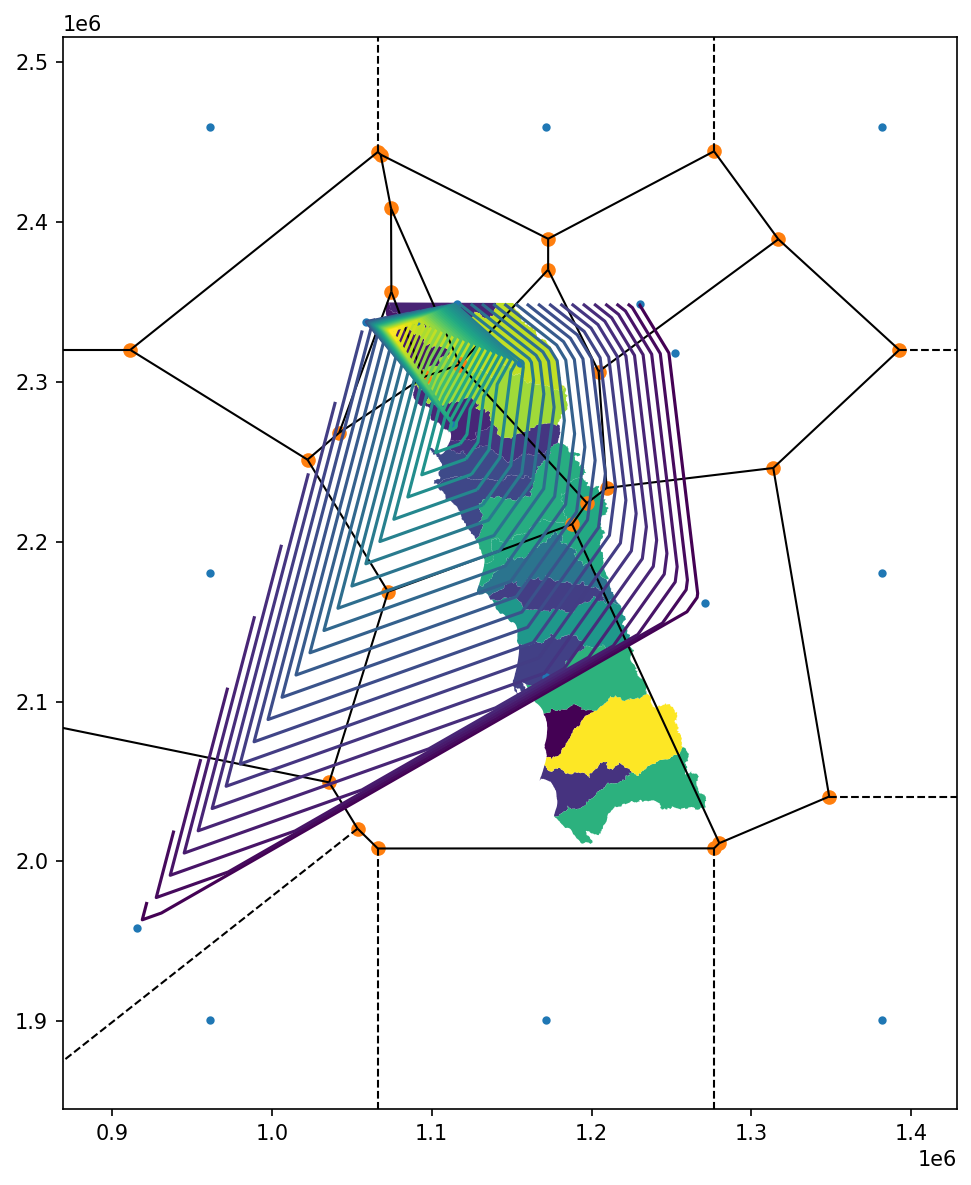

In [19]:
# Polígonos de Thiessen + isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax)
# Graficamos los polígonos de Thiessen.
spatial.voronoi_plot_2d(Thiessen, ax = ax)
# Graficamos las isoyetas.
df_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

In [20]:
Subcuenca = subc[ subc["CVE_SUBCUE"] == "RH01Bd" ].reset_index(drop = True)

Subcuenca

CVE_SUBCUE     SUBCUENCA       TIPO          AREA      PERIMETRO  \
0     RH01Bd  A. El Salado  EXORREICA  1.868140e+09  407083.340466   

                                            geometry CVE_RH  
0  POLYGON ((1207948.053 2206741.772, 1207936.647...   RH01

In [21]:
Subcuenca.explore()

In [22]:
df_is[Subcuenca.loc[0, "CVE_SUBCUE"]] = df_is.intersection(
    Subcuenca.loc[0, "geometry"] )
subc_is = df_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).copy()

subc_is = subc_is[ ~ subc_is.is_empty ].reset_index(drop = True)

subc_is[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"] = ( subc_is.set_geometry(
    "IS_TOT").intersection( Subcuenca.loc[0, "geometry"] ) )

subc_is

hp [mm]                                           geometry  \
0      5.6  LINESTRING (1039705.197 2287389.772, 980123.38...   
1      6.4  LINESTRING (1056539.307 2332073.639, 988864.88...   
2      7.2  LINESTRING (1064780.357 2338843.657, 1059659.5...   
3      8.0  LINESTRING (1071793.826 2340197.412, 1060820.6...   
4      8.8  LINESTRING (1078807.296 2341551.167, 1061981.8...   
5      9.6  LINESTRING (1085820.766 2342904.921, 1063142.9...   
6     10.4  LINESTRING (1092834.235 2344258.676, 1064304.0...   
7     11.2  LINESTRING (1099847.705 2345612.431, 1065465.1...   

                                              IS_TOT  \
0  POLYGON ((1124396.919396122 2348656.839868547,...   
1  POLYGON ((1125164.298796698 2348053.251549101,...   
2  POLYGON ((1131412.045539588 2348655.608636332,...   
3  POLYGON ((1132179.424940164 2348052.020316886,...   
4  POLYGON ((1138427.171683053 2348654.377404117,...   
5  POLYGON ((1139194.551083629 2348050.789084671,...   
6  POLYGON ((1178452.140588822 2313199.341314358,...   
7  POLYGON ((1142384.610336286 2194226.204113949,...   

                                              RH01Bd  \
0  LINESTRING (1204327.390 2179831.258, 1207226.2...   
1  LINESTRING (1198269.789 2185812.873, 1205566.4...   
2  LINESTRING (1190410.369 2189260.787, 1204290.2...   
3  MULTILINESTRING ((1185488.291 2196839.163, 119...   
4  LINESTRING (1179841.964 2203399.108, 1190575.6...   
5  MULTILINESTRING ((1161849.717 2192598.339, 116...   
6  MULTILINESTRING ((1131254.861 2179459.052, 114...   
7  LINESTRING (1138123.223 2192711.817, 1142384.6...   

                                         RH01Bd_POLY  
0  POLYGON ((1204327.390 2179831.258, 1204315.388...  
1  POLYGON ((1198269.789 2185812.873, 1198256.892...  
2  POLYGON ((1204290.257 2208778.550, 1190410.369...  
3  MULTIPOLYGON (((1199968.078 2233462.947, 11999...  
4  POLYGON ((1190575.699 2218492.781, 1179841.964...  
5  MULTIPOLYGON (((1185004.964 2233412.090, 11849...  
6  POLYGON ((1149263.239 2189399.110, 1149230.337...  
7  POLYGON ((1138123.223 2192711.817, 1138123.987...

In [23]:
estaciones[Subcuenca.loc[0, "CVE_SUBCUE"]] = ( estaciones[ "Thiessen"
    ].intersection( Subcuenca.loc[0, "geometry"] ) )
estaciones = estaciones.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"])

subc_th = estaciones[ ~ estaciones.is_empty ].reset_index(drop = True).copy()
subc_th[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_th.area

subc_th

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                      LARUMOROSA  32.272222 -116.205556  Baja California   
1  PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
2                      SAN_FELIPE  31.028050 -114.846660  Baja California   
3                      SANQUINTIN  30.531667 -115.837500  Baja California   

  MUNICIPIO  ALTITUD                                            ARCHIVO  \
0    Tecate   1262.0                   Estacion_LARUMOROSA__90_dias.csv   
1  Ensenada     32.0  Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
2  Mexicali     27.0                   Estacion_SAN_FELIPE__90_dias.csv   
3  Ensenada     32.0                   Estacion_SANQUINTIN__90_dias.csv   

                          geometry             x             y  \
0  POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
1  POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
2  POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06   
3  POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06   

                                            Thiessen  hp_TOT  \
0  POLYGON ((1117550.695 2310977.677, 1172805.057...   14.65   
1  POLYGON ((1094972.637 2302951.373, 1117457.215...   18.60   
2  POLYGON ((1209384.430 2233564.055, 1197126.945...    0.20   
3  POLYGON ((1187752.631 2210872.616, 1279890.670...    5.40   

                                              RH01Bd   RH01Bd_AREA  
0  POLYGON ((1197126.945 2224107.277, 1185820.218...  1.513188e+08  
1  POLYGON ((1197126.945 2224107.277, 1187752.631...  5.178663e+08  
2  POLYGON ((1187752.631 2210872.616, 1197126.945...  6.165250e+08  
3  POLYGON ((1200483.074 2183312.762, 1200457.408...  5.824298e+08

In [24]:
for i in reversed( range(subc_is.shape[0]) ):
    subc_th[f"IS_{subc_is.index[i]}"] = subc_th[
        f"{Subcuenca.loc[0, 'CVE_SUBCUE']}" ].intersection(
        subc_is.loc[ i, f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY" ] )
    subc_th[f"IS_{subc_is.index[i]}_AREA"] = subc_th[
        f"IS_{subc_is.index[i]}"].area

subc_th

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                      LARUMOROSA  32.272222 -116.205556  Baja California   
1  PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
2                      SAN_FELIPE  31.028050 -114.846660  Baja California   
3                      SANQUINTIN  30.531667 -115.837500  Baja California   

  MUNICIPIO  ALTITUD                                            ARCHIVO  \
0    Tecate   1262.0                   Estacion_LARUMOROSA__90_dias.csv   
1  Ensenada     32.0  Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
2  Mexicali     27.0                   Estacion_SAN_FELIPE__90_dias.csv   
3  Ensenada     32.0                   Estacion_SANQUINTIN__90_dias.csv   

                          geometry             x             y  ...  \
0  POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06  ...   
1  POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06  ...   
2  POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06  ...   
3  POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06  ...   

                                                IS_4     IS_4_AREA  \
0  POLYGON ((1185820.218 2236403.360, 1185817.327...  4.111615e+07   
1  POLYGON ((1138116.360 2192660.100, 1138122.962...  4.566470e+08   
2                                      POLYGON EMPTY  0.000000e+00   
3  POLYGON ((1179771.438 2203393.580, 1179714.291...  3.951931e+08   

                                                IS_3     IS_3_AREA  \
0  MULTIPOLYGON (((1185820.218 2236403.360, 11858...  1.190536e+08   
1  POLYGON ((1187752.631 2210872.616, 1138116.360...  5.178663e+08   
2  POLYGON ((1197126.945 2224107.277, 1198951.891...  9.690963e+07   
3  POLYGON ((1185445.152 2196882.403, 1185417.728...  4.795304e+08   

                                                IS_2     IS_2_AREA  \
0  POLYGON ((1185820.218 2236403.360, 1185817.327...  1.513188e+08   
1  POLYGON ((1187752.631 2210872.616, 1138116.360...  5.178663e+08   
2  POLYGON ((1197126.945 2224107.277, 1205947.626...  3.397363e+08   
3  POLYGON ((1190374.056 2189283.801, 1190303.013...  5.386450e+08   

                                                IS_1     IS_1_AREA  \
0  POLYGON ((1185820.218 2236403.360, 1185817.327...  1.513188e+08   
1  POLYGON ((1187752.631 2210872.616, 1138116.360...  5.178663e+08   
2  POLYGON ((1197126.945 2224107.277, 1205947.626...  5.145106e+08   
3  POLYGON ((1198256.892 2185816.471, 1198224.862...  5.801969e+08   

                                                IS_0     IS_0_AREA  
0  POLYGON ((1185820.218 2236403.360, 1185817.327...  1.513188e+08  
1  POLYGON ((1187752.631 2210872.616, 1138116.360...  5.178663e+08  
2  POLYGON ((1197126.945 2224107.277, 1205947.626...  5.947069e+08  
3  POLYGON ((1200457.408 2183312.717, 1200415.701...  5.824298e+08  

[4 rows x 30 columns]

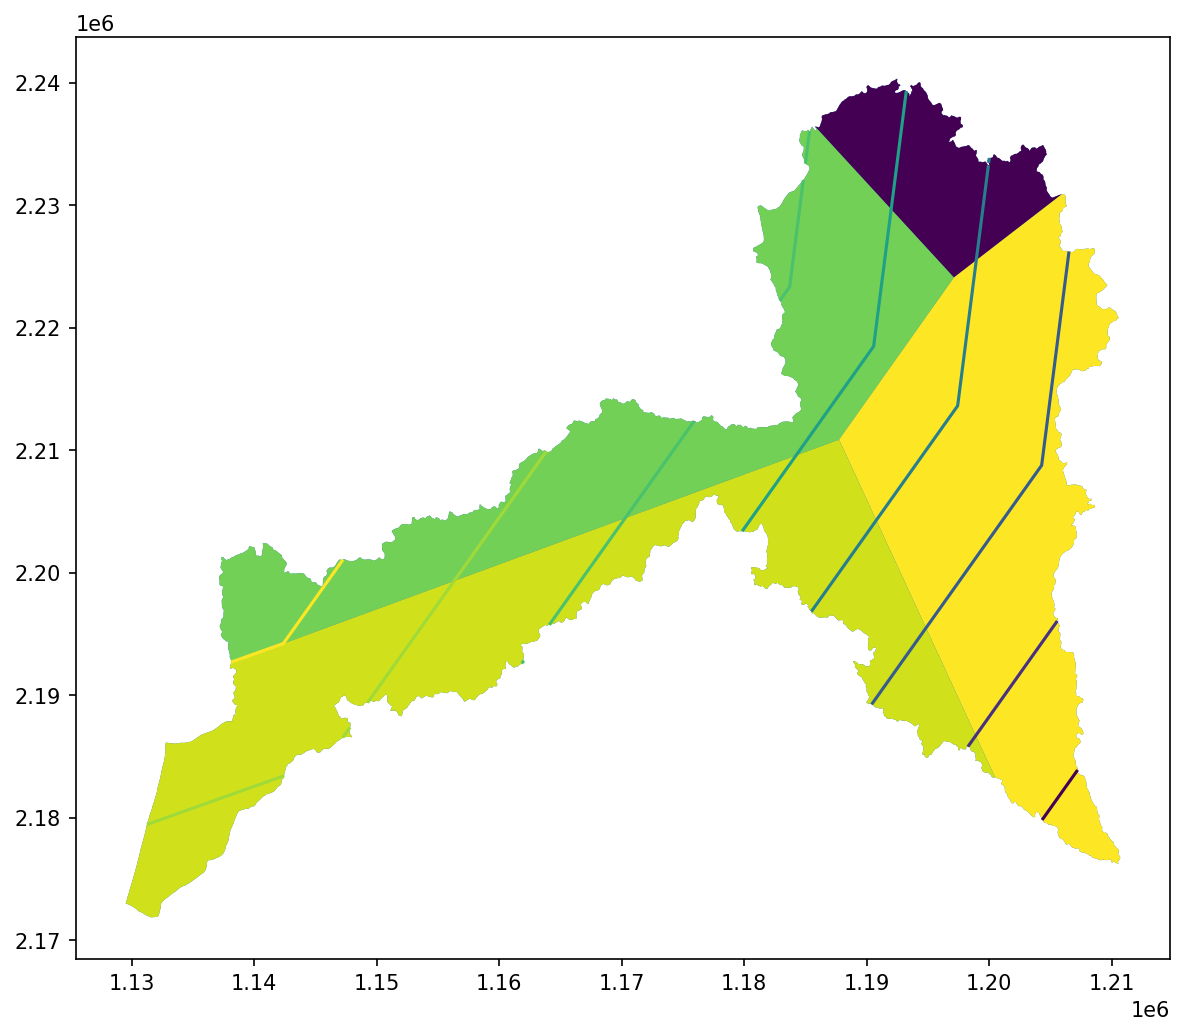

In [25]:
# Polígonos de Thiessen

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax)
# Graficamos los polígonos de Thiessen.
subc_th.plot(f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA", ax = ax)
# Graficamos las isoyetas.
subc_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

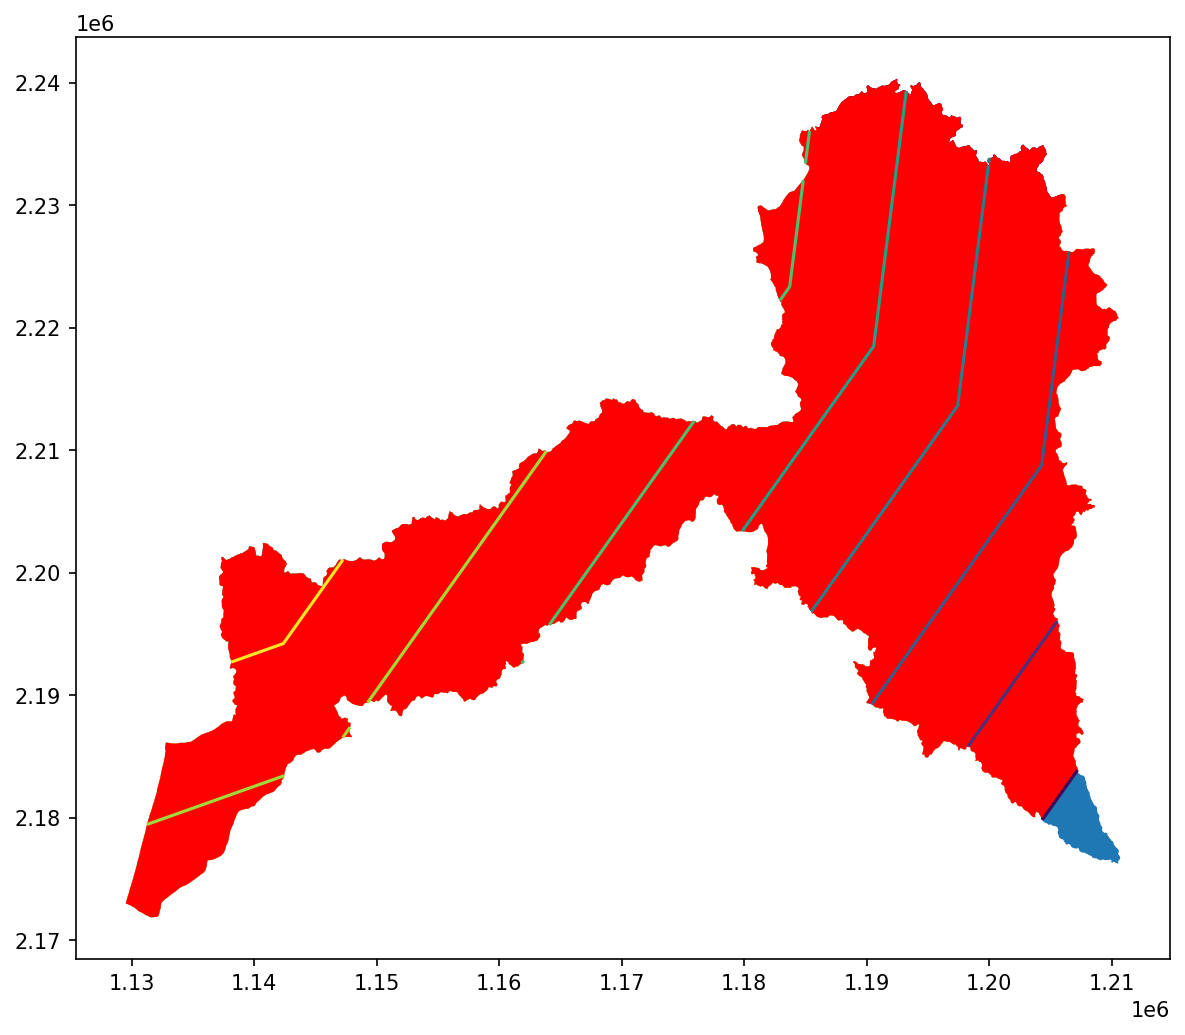

In [26]:
# Polígonos de Thiessen + areas isoyetas

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 0

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax)
# Graficamos los polígonos de Thiessen.
subc_th.set_geometry(f"IS_{i}").plot(f"IS_{i}_AREA", ax = ax)
# Graficamos las isoyetas.
subc_is.set_geometry("RH01Bd").plot("hp [mm]", ax = ax)
subc_is.set_geometry("RH01Bd_POLY").loc[ [0] ].plot(ax = ax, color = "r")

fig.tight_layout()
plt.show()

In [27]:
curva_masa = pluviograma[subc_th["ESTACION"]].cumsum()

curva_masa

LARUMOROSA  PRESAEMILIOLOPEZZAMORAENSENADA  SAN_FELIPE  \
Fecha Local                                                                   
2023-01-01 01:30:00        0.00                             0.0         0.0   
2023-01-01 01:40:00        0.00                             0.0         0.0   
2023-01-01 01:50:00        0.00                             0.0         0.0   
2023-01-01 02:00:00        0.00                             0.0         0.0   
2023-01-01 02:10:00        0.00                             0.0         0.0   
...                         ...                             ...         ...   
2023-01-01 14:50:00       14.40                            18.6         0.2   
2023-01-01 15:00:00       14.40                            18.6         0.2   
2023-01-01 15:10:00       14.65                            18.6         0.2   
2023-01-01 15:20:00       14.65                            18.6         0.2   
2023-01-01 15:30:00       14.65                            18.6         0.2   

                     SANQUINTIN  
Fecha Local                      
2023-01-01 01:30:00         0.0  
2023-01-01 01:40:00         0.0  
2023-01-01 01:50:00         0.0  
2023-01-01 02:00:00         0.0  
2023-01-01 02:10:00         0.0  
...                         ...  
2023-01-01 14:50:00         5.4  
2023-01-01 15:00:00         5.4  
2023-01-01 15:10:00         5.4  
2023-01-01 15:20:00         5.4  
2023-01-01 15:30:00         5.4  

[85 rows x 4 columns]

In [28]:
areas_n = ( [ Subcuenca.loc[0, "CVE_SUBCUE"] ]
    + [ f"IS_{x}"for x in range(subc_is.shape[0]) ] )
areas_n
areas_na = [f"{x}_AREA" for x in areas_n]

In [29]:
hp_th = []

for i in range( len(areas_na) ):
    hp_th.append( ( subc_th["hp_TOT"] * subc_th[areas_na[i]] ).sum()
        / subc_th[areas_na[i]].sum() )

m = []

areas_is = pd.DataFrame( hp_th, columns = ["hp_th"],
    index = areas_n ).reset_index()
areas_is = areas_is.rename( {"index": "AREA"}, axis = 1)

for i in reversed(range( areas_is.shape[0] )):
    if i == areas_is.shape[0] - 1:
        m = [ subc_is.loc[i - 1, f"{areas_n[0]}_POLY"] ] + m
    elif i > 0:
        m = ( [ subc_is.loc[i - 1, f"{areas_n[0]}_POLY"]
            .difference( subc_is.loc[ i, f"{areas_n[0]}_POLY"] ) ] + m )
    else:
        m = ( [ Subcuenca.loc[0, "geometry"].difference(
            subc_is.loc[i, f"{areas_n[0]}_POLY"] ) ] + m )

areas_is["IS_GEOM"] = m
areas_is = gpd.GeoDataFrame( areas_is, geometry = "IS_GEOM" )
areas_is["IS_AREA"] = areas_is.area
#areas_is["IS_hp"] = 

areas_is

AREA      hp_th                                            IS_GEOM  \
0  RH01Bd   8.092306  POLYGON ((1207227.053 2183896.506, 1207232.466...   
1    IS_0   8.185570  POLYGON ((1204315.388 2179837.268, 1204280.863...   
2    IS_1   8.552164  POLYGON ((1198256.892 2185816.471, 1198224.862...   
3    IS_2   9.580050  POLYGON ((1190410.369 2189260.787, 1190401.587...   
4    IS_3  11.526089  MULTIPOLYGON (((1199945.812 2233494.628, 11999...   
5    IS_4  12.576236  MULTIPOLYGON (((1179841.964 2203399.108, 11797...   
6    IS_5  11.150974  MULTIPOLYGON (((1184962.389 2233516.121, 11849...   
7    IS_6  11.158526  POLYGON ((1149230.337 2189402.365, 1149195.393...   
8    IS_7  18.600000  POLYGON ((1138123.223 2192711.817, 1138123.987...   

        IS_AREA  
0  2.181810e+07  
1  8.242926e+07  
2  2.163261e+08  
3  3.342065e+08  
4  3.204036e+08  
5  2.886803e+08  
6  3.083769e+08  
7  2.438366e+08  
8  5.206261e+07

In [30]:
step = subc_is.at[ 1, "hp [mm]" ] - subc_is.at[ 0, "hp [mm]" ]
mid = step / 2

m = ( [subc_is.at[ 0, "hp [mm]" ] - mid ]
    + list(subc_is[ "hp [mm]" ] + mid) )

areas_is["hp_area"] = m

m = []

for i in range(areas_is.shape[0]):

    m.append( ( areas_is.loc[i:, "hp_area"] * areas_is.loc[i:, "IS_AREA"] ).sum()
        / areas_is.loc[i:, "IS_AREA"].sum() )

areas_is["hp_is"] = m
areas_is["Fa"] = areas_is["hp_is"] / areas_is["hp_th"]

areas_is

AREA      hp_th                                            IS_GEOM  \
0  RH01Bd   8.092306  POLYGON ((1207227.053 2183896.506, 1207232.466...   
1    IS_0   8.185570  POLYGON ((1204315.388 2179837.268, 1204280.863...   
2    IS_1   8.552164  POLYGON ((1198256.892 2185816.471, 1198224.862...   
3    IS_2   9.580050  POLYGON ((1190410.369 2189260.787, 1190401.587...   
4    IS_3  11.526089  MULTIPOLYGON (((1199945.812 2233494.628, 11999...   
5    IS_4  12.576236  MULTIPOLYGON (((1179841.964 2203399.108, 11797...   
6    IS_5  11.150974  MULTIPOLYGON (((1184962.389 2233516.121, 11849...   
7    IS_6  11.158526  POLYGON ((1149230.337 2189402.365, 1149195.393...   
8    IS_7  18.600000  POLYGON ((1138123.223 2192711.817, 1138123.987...   

        IS_AREA  hp_area      hp_is        Fa  
0  2.181810e+07      5.2   8.718509  1.077383  
1  8.242926e+07      6.0   8.760088  1.070187  
2  2.163261e+08      6.8   8.889071  1.039394  
3  3.342065e+08      7.6   9.181091  0.958355  
4  3.204036e+08      8.4   9.616585  0.834332  
5  2.886803e+08      9.2  10.053110  0.799374  
6  3.083769e+08     10.0  10.460666  0.938094  
7  2.438366e+08     10.8  10.940758  0.980484  
8  5.206261e+07     11.6  11.600000  0.623656

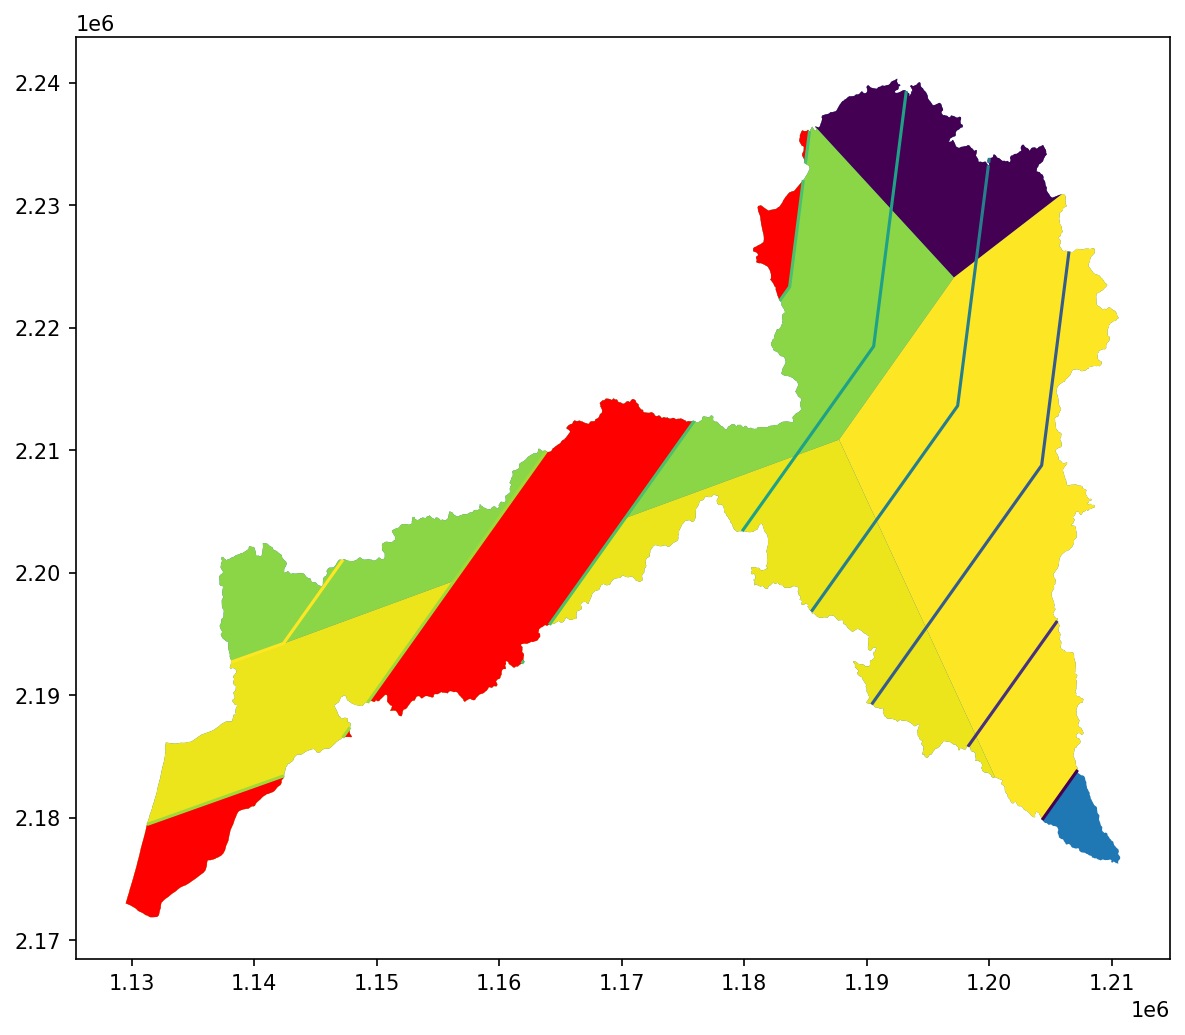

In [31]:
# Polígonos de Thiessen + areas isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 0

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax)
# Graficamos los polígonos de Thiessen.
subc_th.set_geometry(f"IS_{i}").plot(f"IS_{i}_AREA", ax = ax)
# Graficamos las isoyetas.
subc_is.set_geometry("RH01Bd").plot("hp [mm]", ax = ax)
areas_is.loc[ [6] ].plot(ax = ax, color = "r")

fig.tight_layout()
plt.show()

In [32]:
for j in range( len(areas_na) ):

    for i in range( subc_th.shape[0] ):
        curva_masa[f"{curva_masa.columns[i]}_Ath"] = ( curva_masa[
            f"{curva_masa.columns[i]}"] * subc_th.loc[i, areas_na[j]] )

    curva_masa[areas_n[j]] = ( curva_masa[
        [f"{curva_masa.columns[i]}_Ath" for i in range( subc_th.shape[0] ) ]
        ].sum(axis = 1) / subc_th[areas_na[j]].sum() * areas_is.loc[j, "Fa"] )

    curva_masa = curva_masa.drop( [f"{curva_masa.columns[i]}_Ath"
        for i in range( subc_th.shape[0] ) ], axis = 1)

curva_masa

LARUMOROSA  PRESAEMILIOLOPEZZAMORAENSENADA  SAN_FELIPE  \
Fecha Local                                                                   
2023-01-01 01:30:00        0.00                             0.0         0.0   
2023-01-01 01:40:00        0.00                             0.0         0.0   
2023-01-01 01:50:00        0.00                             0.0         0.0   
2023-01-01 02:00:00        0.00                             0.0         0.0   
2023-01-01 02:10:00        0.00                             0.0         0.0   
...                         ...                             ...         ...   
2023-01-01 14:50:00       14.40                            18.6         0.2   
2023-01-01 15:00:00       14.40                            18.6         0.2   
2023-01-01 15:10:00       14.65                            18.6         0.2   
2023-01-01 15:20:00       14.65                            18.6         0.2   
2023-01-01 15:30:00       14.65                            18.6         0.2   

                     SANQUINTIN    RH01Bd      IS_0      IS_1      IS_2  \
Fecha Local                                                               
2023-01-01 01:30:00         0.0  0.000000  0.000000  0.000000  0.000000   
2023-01-01 01:40:00         0.0  0.000000  0.000000  0.000000  0.000000   
2023-01-01 01:50:00         0.0  0.000000  0.000000  0.000000  0.000000   
2023-01-01 02:00:00         0.0  0.000000  0.000000  0.000000  0.000000   
2023-01-01 02:10:00         0.0  0.000000  0.000000  0.000000  0.000000   
...                         ...       ...       ...       ...       ...   
2023-01-01 14:50:00         5.4  8.696693  8.738161  8.866779  9.157664   
2023-01-01 15:00:00         5.4  8.696693  8.738161  8.866779  9.157664   
2023-01-01 15:10:00         5.4  8.718509  8.760088  8.889071  9.181091   
2023-01-01 15:20:00         5.4  8.718509  8.760088  8.889071  9.181091   
2023-01-01 15:30:00         5.4  8.718509  8.760088  8.889071  9.181091   

                         IS_3       IS_4       IS_5       IS_6  IS_7  
Fecha Local                                                           
2023-01-01 01:30:00  0.000000   0.000000   0.000000   0.000000   0.0  
2023-01-01 01:40:00  0.000000   0.000000   0.000000   0.000000   0.0  
2023-01-01 01:50:00  0.000000   0.000000   0.000000   0.000000   0.0  
2023-01-01 02:00:00  0.000000   0.000000   0.000000   0.000000   0.0  
2023-01-01 02:10:00  0.000000   0.000000   0.000000   0.000000   0.0  
...                       ...        ...        ...        ...   ...  
2023-01-01 14:50:00  9.596119  10.043909  10.460666  10.940758  11.6  
2023-01-01 15:00:00  9.596119  10.043909  10.460666  10.940758  11.6  
2023-01-01 15:10:00  9.616585  10.053110  10.460666  10.940758  11.6  
2023-01-01 15:20:00  9.616585  10.053110  10.460666  10.940758  11.6  
2023-01-01 15:30:00  9.616585  10.053110  10.460666  10.940758  11.6  

[85 rows x 13 columns]

In [33]:
areas_n

['RH01Bd', 'IS_0', 'IS_1', 'IS_2', 'IS_3', 'IS_4', 'IS_5', 'IS_6', 'IS_7']

In [34]:
# Duración.

# Calculamos el delta de tiempo.
dt = ( curva_masa.index[1] - curva_masa.index[0] ) / pd.Timedelta( hours = 1 )

duracion = pd.DataFrame( np.arange(dt, dt * curva_masa.shape[0], dt ),
    columns = ["Duración"])

for i in range( len(areas_n) ):

    # Copiamos la columna de curva masa a un nuevo dataframe.
    dur = curva_masa[ [areas_n[i]] ].copy()

    # Para cada duración desde dt hasta dt * cantidad de filas, la duración
    # es la curva masa menos la curva masa recorrida.
    for j in range( 1, dur.shape[0] ):
        dur[dt * j ] = dur[ areas_n[i] ] - dur[ areas_n[i] ].shift(j)

    # Quitamos la columna de la curva masa.
    dur.drop(areas_n[i], axis = 1, inplace = True)

    # Creamos un nuevo dataframe para la tabla de duración.
    dur = pd.DataFrame( dur.max(axis = 0),
    columns = [ subc_th[areas_na[i]].sum() ] ).reset_index( drop = True )

    duracion = pd.concat( [duracion, dur], axis = 1 )

duracion = duracion.set_index("Duración")

duracion = duracion.T
duracion.index.name = ("Área")

duracion

Duración            0.166667   0.333333   0.500000   0.666667   0.833333   \
Área                                                                        
1868139890.1900544   1.717007   2.164413   2.887790   3.327732   3.752449   
1846321790.4162226   1.725693   2.175363   2.902400   3.344567   3.771433   
1763892528.2204025   1.754364   2.211504   2.950620   3.400134   3.834091   
1547566422.106179    1.843693   2.324111   3.100861   3.573263   4.029317   
1213359964.5992007   2.035887   2.554887   3.392331   3.911331   4.400862   
892956332.3258607    2.307995   2.889503   3.763398   4.344905   4.863427   
604276019.6709753    2.288769   2.860962   3.678379   4.250572   4.741022   
295899165.3742379    2.395334   2.994167   3.849643   4.448477   4.961762   
52062609.66218526    3.492473   4.365591   5.612903   6.486022   7.234409   

Duración            1.000000   1.166667   1.333333   1.500000   1.666667   \
Área                                                                        
1868139890.1900544   4.177165   4.505107   4.817823   5.257765   5.421735   
1846321790.4162226   4.198298   4.527898   4.842196   5.284364   5.449165   
1763892528.2204025   4.268048   4.603125   4.922644   5.372158   5.539697   
1547566422.106179    4.485370   4.837508   5.173298   5.645700   5.821769   
1213359964.5992007   4.890394   5.258771   5.597681   6.116681   6.300870   
892956332.3258607    5.381948   5.746523   6.048112   6.629620   6.811908   
604276019.6709753    5.231473   5.558440   5.803665   6.375857   6.539341   
295899165.3742379    5.475048   5.817239   6.073882   6.672715   6.843810   
52062609.66218526    7.982796   8.481720   8.855914   9.729032   9.978495   

Duración            ...  12.500000  12.666667  12.833333  13.000000  \
Área                ...                                               
1868139890.1900544  ...   8.718509   8.718509   8.718509   8.718509   
1846321790.4162226  ...   8.760088   8.760088   8.760088   8.760088   
1763892528.2204025  ...   8.889071   8.889071   8.889071   8.889071   
1547566422.106179   ...   9.181091   9.181091   9.181091   9.181091   
1213359964.5992007  ...   9.616585   9.616585   9.616585   9.616585   
892956332.3258607   ...  10.053110  10.053110  10.053110  10.053110   
604276019.6709753   ...  10.460666  10.460666  10.460666  10.460666   
295899165.3742379   ...  10.940758  10.940758  10.940758  10.940758   
52062609.66218526   ...  11.600000  11.600000  11.600000  11.600000   

Duración            13.166667  13.333333  13.500000  13.666667  13.833333  \
Área                                                                        
1868139890.1900544   8.718509   8.718509   8.718509   8.718509   8.718509   
1846321790.4162226   8.760088   8.760088   8.760088   8.760088   8.760088   
1763892528.2204025   8.889071   8.889071   8.889071   8.889071   8.889071   
1547566422.106179    9.181091   9.181091   9.181091   9.181091   9.181091   
1213359964.5992007   9.616585   9.616585   9.616585   9.616585   9.616585   
892956332.3258607   10.053110  10.053110  10.053110  10.053110  10.053110   
604276019.6709753   10.460666  10.460666  10.460666  10.460666  10.460666   
295899165.3742379   10.940758  10.940758  10.940758  10.940758  10.940758   
52062609.66218526   11.600000  11.600000  11.600000  11.600000  11.600000   

Duración            14.000000  
Área                           
1868139890.1900544   8.718509  
1846321790.4162226   8.760088  
1763892528.2204025   8.889071  
1547566422.106179    9.181091  
1213359964.5992007   9.616585  
892956332.3258607   10.053110  
604276019.6709753   10.460666  
295899165.3742379   10.940758  
52062609.66218526   11.600000  

[9 rows x 84 columns]

(1.0, 16.0)

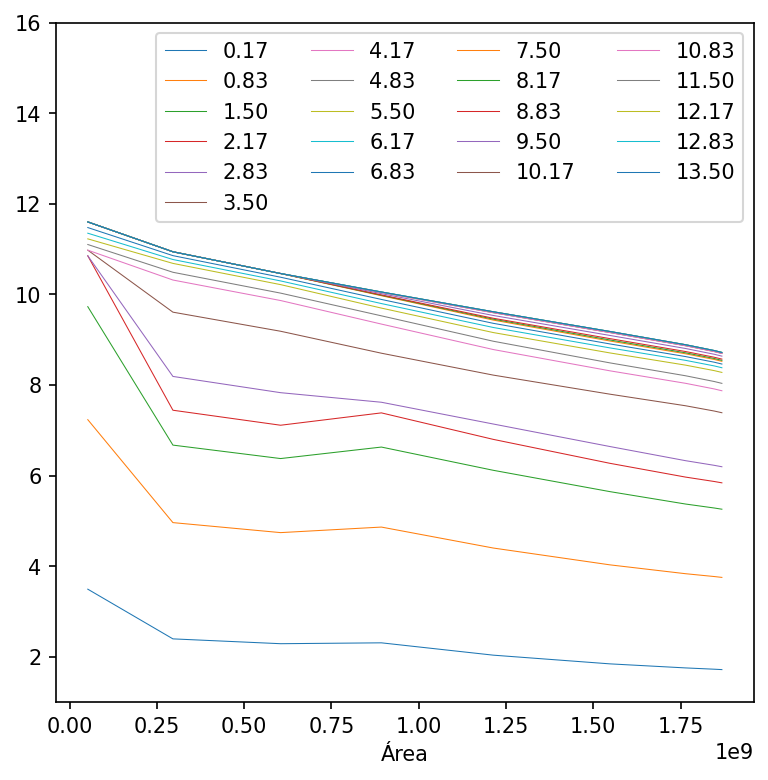

In [35]:
# Curvas h - a - d.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

duracion.iloc[ :, ::4 ].plot(ax = ax, linewidth = 0.5)

# Estilo.
handles, labels = ax.get_legend_handles_labels()
labels = [f"{float(x):.2f}" for x in labels]
ax.legend(handles, labels, ncol = 4)
ax.set_ylim(1, 16)

In [36]:
A = Subcuenca.loc[0, "AREA"] / 2
i = ( duracion.index > A ).sum()

p = ( ( A - duracion.index[i - 1] )
    / ( duracion.index[i] - duracion.index[i - 1] ) )

precipitacion_A = ( ( duracion.iloc[i] - duracion.iloc[i - 1] )
    * p + duracion.iloc[i - 1] )

precipitacion_A.name = "curva masa [mm]"
precipitacion_A.index.name = "tiempo [h]"

precipitacion_A[0.0] = 0
precipitacion_A = precipitacion_A.sort_index()

precipitacion_A = pd.DataFrame( precipitacion_A )

precipitacion_A["hp [mm]"] = ( precipitacion_A["curva masa [mm]"]
    - precipitacion_A["curva masa [mm]"].shift(1) )
precipitacion_A.loc[0.0, "hp [mm]"] = 0

precipitacion_A["i [mm/h]"] = precipitacion_A["hp [mm]"] / dt

precipitacion_A

curva masa [mm]   hp [mm]   i [mm/h]
tiempo [h]                                      
0.000000           0.000000  0.000000   0.000000
0.166667           2.273079  2.273079  13.638473
0.333333           2.846566  0.573487   3.440921
0.500000           3.715783  0.869217   5.215304
0.666667           4.289270  0.573487   3.440921
...                     ...       ...        ...
13.333333          9.997096  0.000000   0.000000
13.500000          9.997096  0.000000   0.000000
13.666667          9.997096  0.000000   0.000000
13.833333          9.997096  0.000000   0.000000
14.000000          9.997096  0.000000   0.000000

[85 rows x 3 columns]

(0.0, 10.49695093913774)

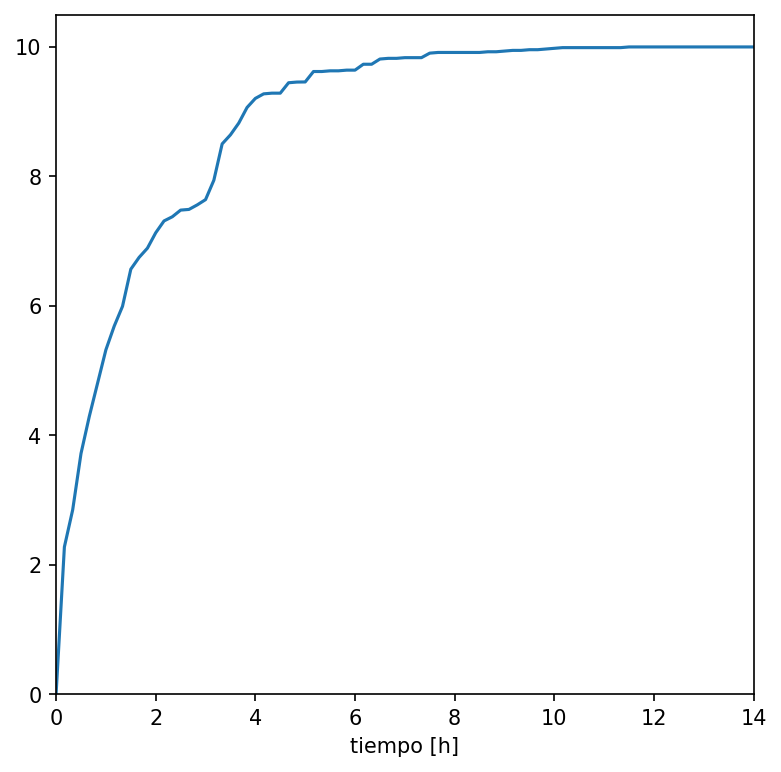

In [37]:
# Curva masa.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

precipitacion_A["curva masa [mm]"].plot(ax = ax)

# Estilo.
ax.set_xlim(0, 14)
ax.set_ylim(0)

(0.0, 2.386732815085167)

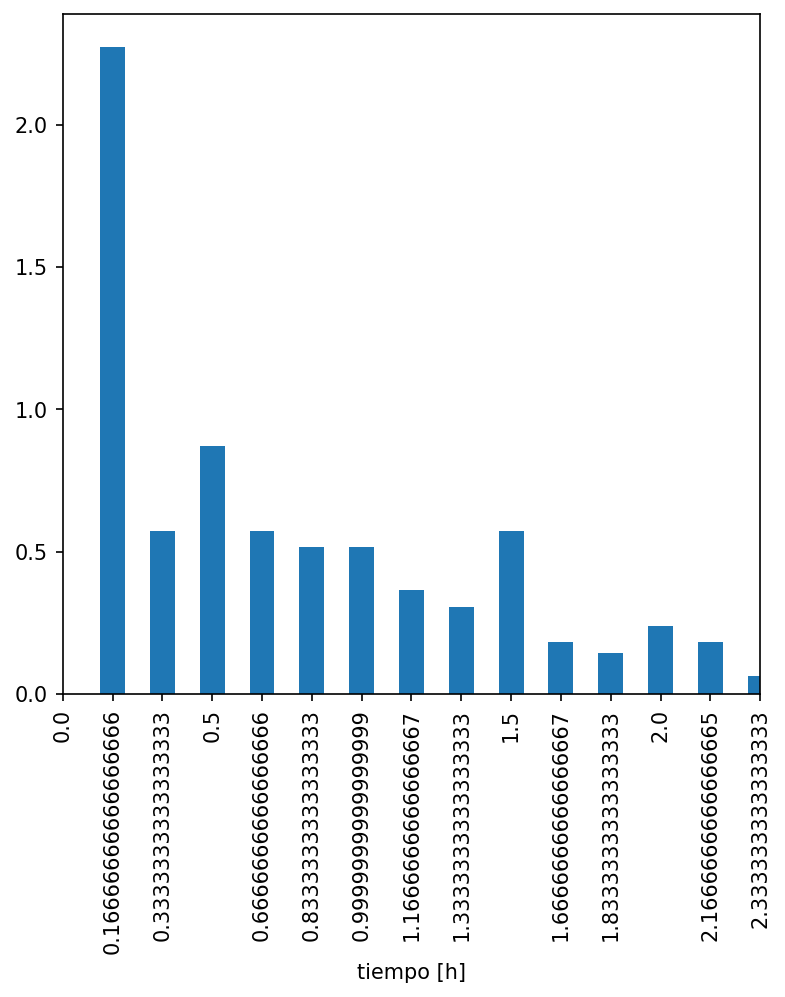

In [38]:
# Hietograma.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

precipitacion_A["hp [mm]"].plot.bar(ax = ax)

# Estilo.
ax.set_xlim(0, 14)
ax.set_ylim(0)